<a href="https://colab.research.google.com/github/mhanauer/xgboost_drop_out_colab/blob/mhanauer-patch-1/xgboost_drop_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
# To make things easier later, we're also importing numpy and pandas for
# working with sample data.
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, chi2

Guidance on uploading csv's:https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

In [67]:
# import new data
from google.colab import files
drop_out_dat = files.upload()
# Na's already cleaned in R
import io
drop_out_dat = pd.read_csv(io.BytesIO(drop_out_dat['drop_dat_9_23_20.csv']))
drop_out_dat

Saving drop_dat_9_23_20.csv to drop_dat_9_23_20 (7).csv


,Quarter,Gender,RaceWhite,RaceBlack,Agegroup,OverallHealth,CapableManagingHealthCareNeeds,HandlingDailyLife,ControlLife,DealWithCrisis,GetsAlongWithFamily,SocialSituations,FunctioningHousing,Symptoms,Nervous,Hopeless,Restless,Depressed,EverythingEffort,Worthless,PsychologicalEmotionalProblems,LifeQuality,EnoughEnergyForEverydayLife,PerformDailyActivitiesSatisfaction,HealthSatisfaction,RelationshipSatisfaction,SelfSatisfaction,Tobacco_Use,Alcohol_Use,Cannabis_Use,ViolenceTrauma,Housing,Education,Employment,EnoughMoneyForNeeds,Friendships,EnjoyPeople,BelongInCommunity,SupportFromFamily,SupportiveFamilyFriends,GenerallyAccomplishGoal,telehealth,grant,EverServed,ActiveDuty_Else,NightsHomeless,drop_out,aiety,mdd_r,mdd_s,another_s_ident,drug_use,er_hos_use_base,jail_arrest_base
0,2,0.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.0,1.0,0.0,6.0,4.0,2.0,2.0,3.0,4.0,NaN,2.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,0.0,3.0,3.0,2.0,4.0,2.0,2.0,3.0,4.0,1.0,1.0,0.0,0.0,14.0,1.0,1.0,2.0,3.0,2.0,4.0,4.0,2.0,0,1,0.0,1.0,0.0,0,1.0,0.0,0.0,0.0,9.0,0.0,0.0
2,2,0.0,1.0,0.0,7.0,5.0,2.0,4.0,3.0,4.0,4.0,4.0,1.0,1.0,2.0,0.0,1.0,2.0,3.0,0.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,4.0,1.0,1.0,0.0,0.0,13.0,0.0,1.0,4.0,1.0,1.0,2.0,2.0,4.0,0,1,0.0,0.0,14.0,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
3,3,0.0,1.0,0.0,6.0,4.0,3.0,2.0,4.0,4.0,4.0,2.0,2.0,5.0,4.0,2.0,3.0,3.0,4.0,2.0,4.0,2.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,14.0,0.0,3.0,2.0,4.0,2.0,4.0,4.0,2.0,0,1,0.0,1.0,0.0,0,0.0,0.0,0.0,1.0,15.0,0.0,0.0
4,4,0.0,1.0,0.0,7.0,5.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,2.0,2.0,0.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,4.0,2.0,1.0,1.0,1.0,0.0,1.0,14.0,0.0,2.0,4.0,4.0,4.0,2.0,2.0,3.0,0,1,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,12.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,2,1.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1283,3,1.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,0,0.0,0.0,0.0,NaN,NaN,0.0,NaN
1284,4,0.0,1.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,1.0,3.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,0,0.0,0.0,1.0,NaN,NaN,0.0,NaN
1285,4,0.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,0,1.0,0.0,0.0,NaN,NaN,0.0,NaN


In [68]:
# Get predictor names
drop_out_dat_names = drop_out_dat.columns
drop_out_dat_names

Index(['Quarter', 'Gender', 'RaceWhite', 'RaceBlack', 'Agegroup',
       'OverallHealth', 'CapableManagingHealthCareNeeds', 'HandlingDailyLife',
       'ControlLife', 'DealWithCrisis', 'GetsAlongWithFamily',
       'SocialSituations', 'FunctioningHousing', 'Symptoms', 'Nervous',
       'Hopeless', 'Restless', 'Depressed', 'EverythingEffort', 'Worthless',
       'PsychologicalEmotionalProblems', 'LifeQuality',
       'EnoughEnergyForEverydayLife', 'PerformDailyActivitiesSatisfaction',
       'HealthSatisfaction', 'RelationshipSatisfaction', 'SelfSatisfaction',
       'Tobacco_Use', 'Alcohol_Use', 'Cannabis_Use', 'ViolenceTrauma',
       'Housing', 'Education', 'Employment', 'EnoughMoneyForNeeds',
       'Friendships', 'EnjoyPeople', 'BelongInCommunity', 'SupportFromFamily',
       'SupportiveFamilyFriends', 'GenerallyAccomplishGoal', 'telehealth',
       'grant', 'EverServed', 'ActiveDuty_Else', 'NightsHomeless', 'drop_out',
       'aiety', 'mdd_r', 'mdd_s', 'another_s_ident', 'drug_use

Check out this example for comparing imputation methods: https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html#sphx-glr-auto-examples-impute-plot-iterative-imputer-variants-comparison-py
To see the defaults for IterativeImputer: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer

In [69]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_iterative = IterativeImputer(max_iter=10, random_state=0)
test = imp_iterative.fit_transform(drop_out_dat)
drop_out_dat = pd.DataFrame(test)
drop_out_dat.columns = drop_out_dat_names
drop_out_dat
#drop_out_dat.isna().sum()


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



,Quarter,Gender,RaceWhite,RaceBlack,Agegroup,OverallHealth,CapableManagingHealthCareNeeds,HandlingDailyLife,ControlLife,DealWithCrisis,GetsAlongWithFamily,SocialSituations,FunctioningHousing,Symptoms,Nervous,Hopeless,Restless,Depressed,EverythingEffort,Worthless,PsychologicalEmotionalProblems,LifeQuality,EnoughEnergyForEverydayLife,PerformDailyActivitiesSatisfaction,HealthSatisfaction,RelationshipSatisfaction,SelfSatisfaction,Tobacco_Use,Alcohol_Use,Cannabis_Use,ViolenceTrauma,Housing,Education,Employment,EnoughMoneyForNeeds,Friendships,EnjoyPeople,BelongInCommunity,SupportFromFamily,SupportiveFamilyFriends,GenerallyAccomplishGoal,telehealth,grant,EverServed,ActiveDuty_Else,NightsHomeless,drop_out,aiety,mdd_r,mdd_s,another_s_ident,drug_use,er_hos_use_base,jail_arrest_base
0,2.0,0.0,0.881776,0.093999,5.0,3.473369,1.506143,3.583555,3.558809,3.375207,3.654192,3.312744,3.664423,2.507835,2.594542,1.605692,2.444473,1.407958,2.129853,1.477005,3.476289,3.436342,2.837805,3.242512,3.004927,3.377013,3.107397,2.285144,1.443553,1.604213,0.797644,0.653483,13.063686,0.455399,2.946530,3.628207,3.865799,3.454282,4.013450,4.107554,3.711749,0.0,1.0,0.041110,0.970296,1.503451,0.0,0.346253,0.161903,0.163307,0.213910,9.471390,0.891383,0.407408
1,2.0,0.0,1.000000,0.000000,6.0,4.000000,2.000000,2.000000,3.000000,4.000000,3.274759,2.000000,4.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,3.000000,3.000000,2.000000,4.000000,2.000000,2.000000,3.000000,4.000000,1.000000,1.000000,0.000000,0.000000,14.000000,1.000000,1.000000,2.000000,3.000000,2.000000,4.000000,4.000000,2.000000,0.0,1.0,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000
2,2.0,0.0,1.000000,0.000000,7.0,5.000000,2.000000,4.000000,3.000000,4.000000,4.000000,4.000000,1.000000,1.000000,2.000000,0.000000,1.000000,2.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,4.000000,1.000000,1.000000,0.000000,0.000000,13.000000,0.000000,1.000000,4.000000,1.000000,1.000000,2.000000,2.000000,4.000000,0.0,1.0,0.000000,0.000000,14.000000,0.0,0.000000,0.000000,0.000000,0.000000,9.267589,0.000000,0.000000
3,3.0,0.0,1.000000,0.000000,6.0,4.000000,3.000000,2.000000,4.000000,4.000000,4.000000,2.000000,2.000000,5.000000,4.000000,2.000000,3.000000,3.000000,4.000000,2.000000,4.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,0.000000,3.000000,2.000000,4.000000,2.000000,4.000000,4.000000,2.000000,0.0,1.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,15.000000,0.000000,0.000000
4,4.0,0.0,1.000000,0.000000,7.0,5.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,2.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,4.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,14.000000,0.000000,2.000000,4.000000,4.000000,4.000000,2.000000,2.000000,3.000000,0.0,1.0,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,12.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,2.0,1.0,1.000000,0.000000,2.0,2.648621,1.370377,4.112866,4.007091,3.833582,4.033422,3.702417,4.244583,3.033737,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.851637,3.950478,3.731829,3.775861,3.657539,3.831381,3.564639,1.000000,1.000000,1.694768,0.743921,1.000000,13.155403,0.751471,3.601341,4.080795,4.356771,3.747198,4.349064,4.576189,4.037521,0.0,0.0,0.032616,0.943423,0.000000,0.0,0.246217,0.146534,0.049235,0.287449,9.592286,0.000000,0.406813
1283,3.0,1.0,0.000000,1.000000,2.0,2.751738,1.480478,3.859257,3.955886,3.719937,3.922971,3.587033,3.991437,2.851635,1.788574,1.311290,2.394730,1.040733,2.107517,0.994703,3.089115,3.852994,3.502025,3.567252,3.459869,3.692955,3.519841,1.67

In [70]:
y = drop_out_dat[["drop_out"]]
predictors = drop_out_dat.drop(["drop_out"], axis = 1)
### Needed to get y in the correct format
y = y.values.ravel()
## Save for later to keep predictor names
predictors_names = predictors
### Needed for xgboost
predictors = predictors.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(predictors, y, test_size = .20, random_state = 53)


For scale_pos_weight, generally take the sum(neg) / sum(pos) are starting point for imbalanced data sets.


In [71]:
y_ratio = drop_out_dat[["drop_out"]]
y_ratio = 1-y_ratio.mean(axis=0)
y_ratio 

drop_out    0.790987
dtype: float64

Do feature selection first, then do your randomized search: https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-02-11262b7f7a5c
Doing feature selection with balanced accuracy plotting below

In [72]:
from sklearn.feature_selection import RFECV
# Set the hyperparameters for the classifier
classifier = XGBClassifier(learning_rate = .01, max_depth= 12, colsample_bytree = .7, scale_pos_weight = 0.790987)
## Now run the cross validated feature selection
selector = RFECV(classifier, step = 1, cv = 10, scoring = "balanced_accuracy")
selector.fit(X_train, y_train)


RFECV(cv=10,
      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7, gamma=0, learning_rate=0.01,
                              max_delta_step=0, max_depth=12,
                              min_child_weight=1, missing=None,
                              n_estimators=100, n_jobs=1, nthread=None,
                              objective='binary:logistic', random_state=0,
                              reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=0.790987, seed=None, silent=None,
                              subsample=1, verbosity=1),
      min_features_to_select=1, n_jobs=None, scoring='balanced_accuracy',
      step=1, verbose=0)

Show the how accurate the features are 

In [75]:
selector.grid_scores_

array([0.66321676, 0.65394782, 0.74448961, 0.72551512, 0.76360283,
       0.75818063, 0.7630006 , 0.76177356, 0.76361036, 0.76177356,
       0.76653547, 0.7695337 , 0.77368585, 0.76770443, 0.777838  ,
       0.77600873, 0.77069514, 0.77191466, 0.7730761 , 0.77845528,
       0.77191466, 0.77008539, 0.76770443, 0.76892395, 0.76831419,
       0.76715275, 0.7695337 , 0.76770443, 0.76770443, 0.77246634,
       0.76593324, 0.76471373, 0.76587517, 0.76349421, 0.77246634,
       0.76709468, 0.76409644, 0.76703661, 0.77062954, 0.77484729,
       0.76532348, 0.77246634, 0.7730105 , 0.76471373, 0.77246634,
       0.7694025 , 0.76586764, 0.76049598, 0.76708715, 0.76348669,
       0.76531595, 0.76232525, 0.762935  ])

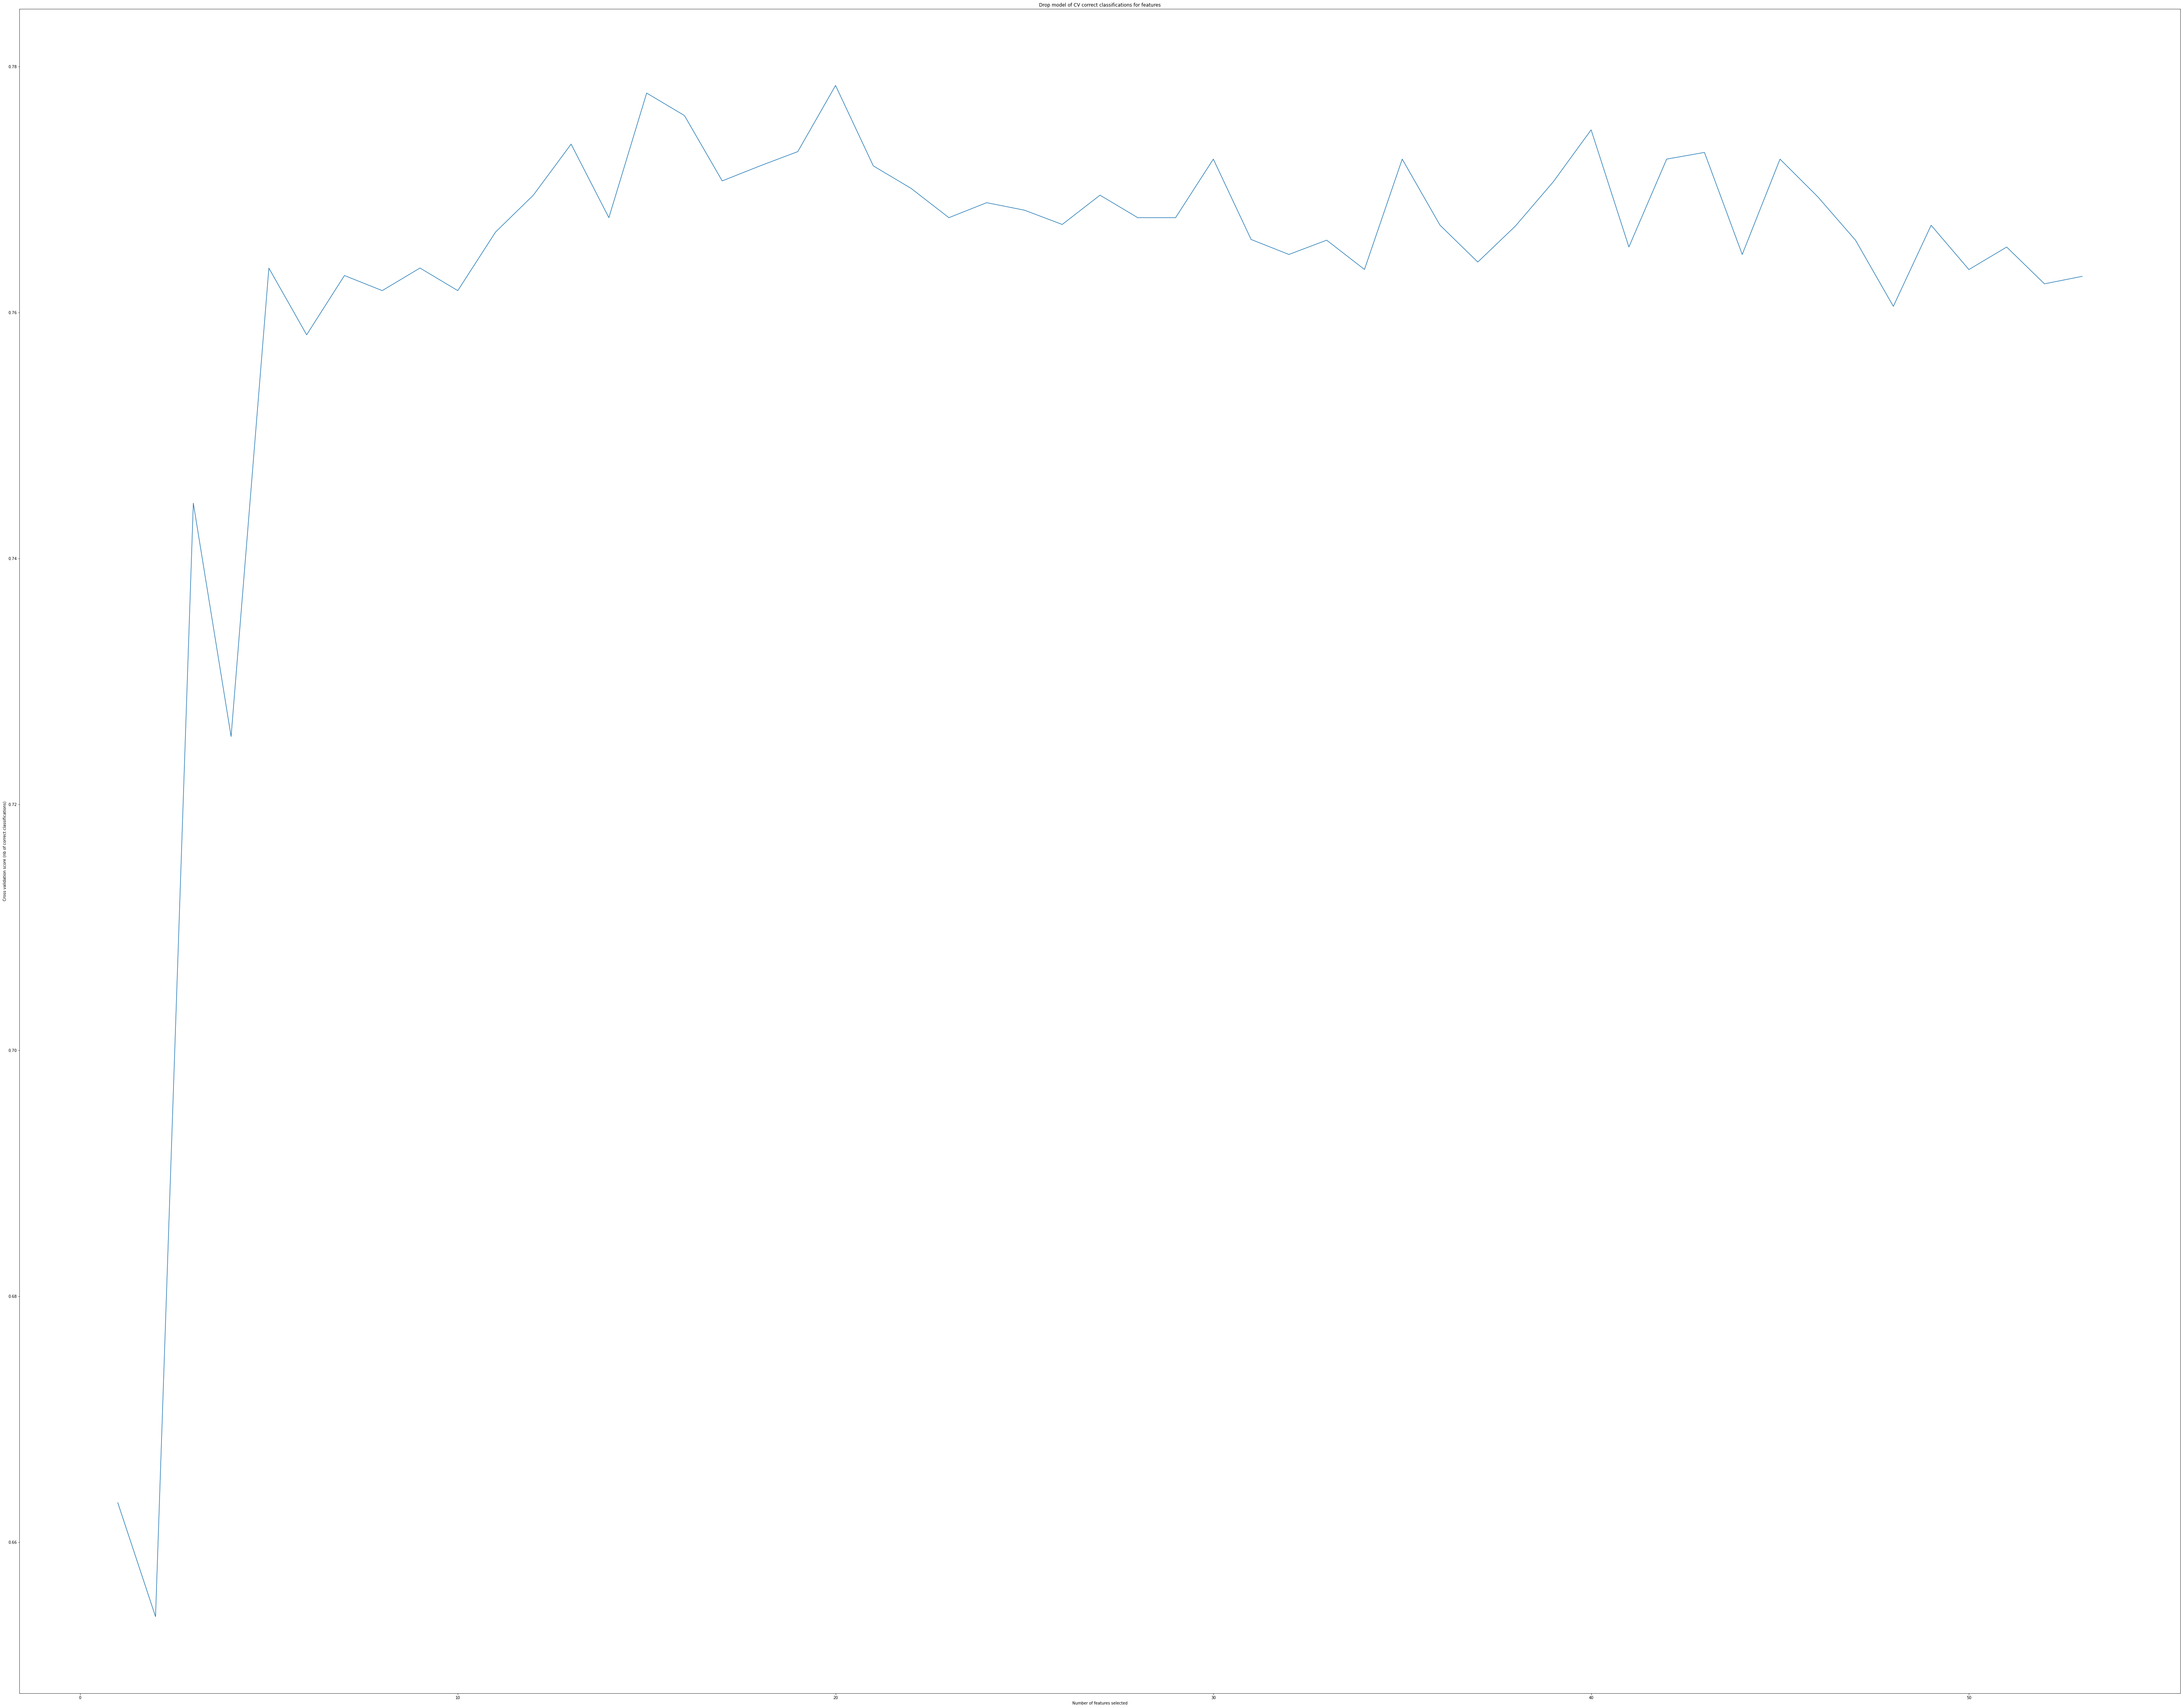

In [76]:
import matplotlib.pyplot as plt
plt.figure()
plt.title('Drop model of CV correct classifications for features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

Now just select the features you want

In [77]:
X_test = X_test[:, selector.support_]
X_train = X_train[:, selector.support_]
X_test.shape

(258, 20)

Develop a pipline for cleaner inclusion of hyparameter tuning
Then run randomized grid search through the hyperparameters. 

You are doing cross validation feature selection first with Cross valdiation.
See here for code: https://intellipaat.com/community/3280/how-to-perform-feature-selection-with-gridsearchcv-in-sklearn-in-python
You have do the recusive feature elimination without knowing the best estimator.

In [78]:
### 
params = {  
    "max_depth": [6,12,15, 18],
    "eta": [.01, .001, .3, .4, .5, .6, .7],
    "colsample_bytree": [.3, .4,.5, .6, .7, .8, .9],
    "subsample": [.5, .6, .7],
    "lambda": [1, 1.1, 1.2, 1.3, 1.4],
    "alpha": [0, .1, .2, .3],
    "scale_pos_weight": [ 0.725799,  0.725799+.1,  0.725799-.1]
}
classifier = XGBClassifier()
gs = RandomizedSearchCV(classifier, param_distributions= params, n_jobs=-1, cv = 10, scoring = "balanced_accuracy")
gs.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, s...
                   param_distributions={'alpha': [0, 0.1, 0.2, 0.3],
                                        'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                           

Leaves are log odds so take 1/(1+ np.exp(-(leaf))) to get the probabilities.  

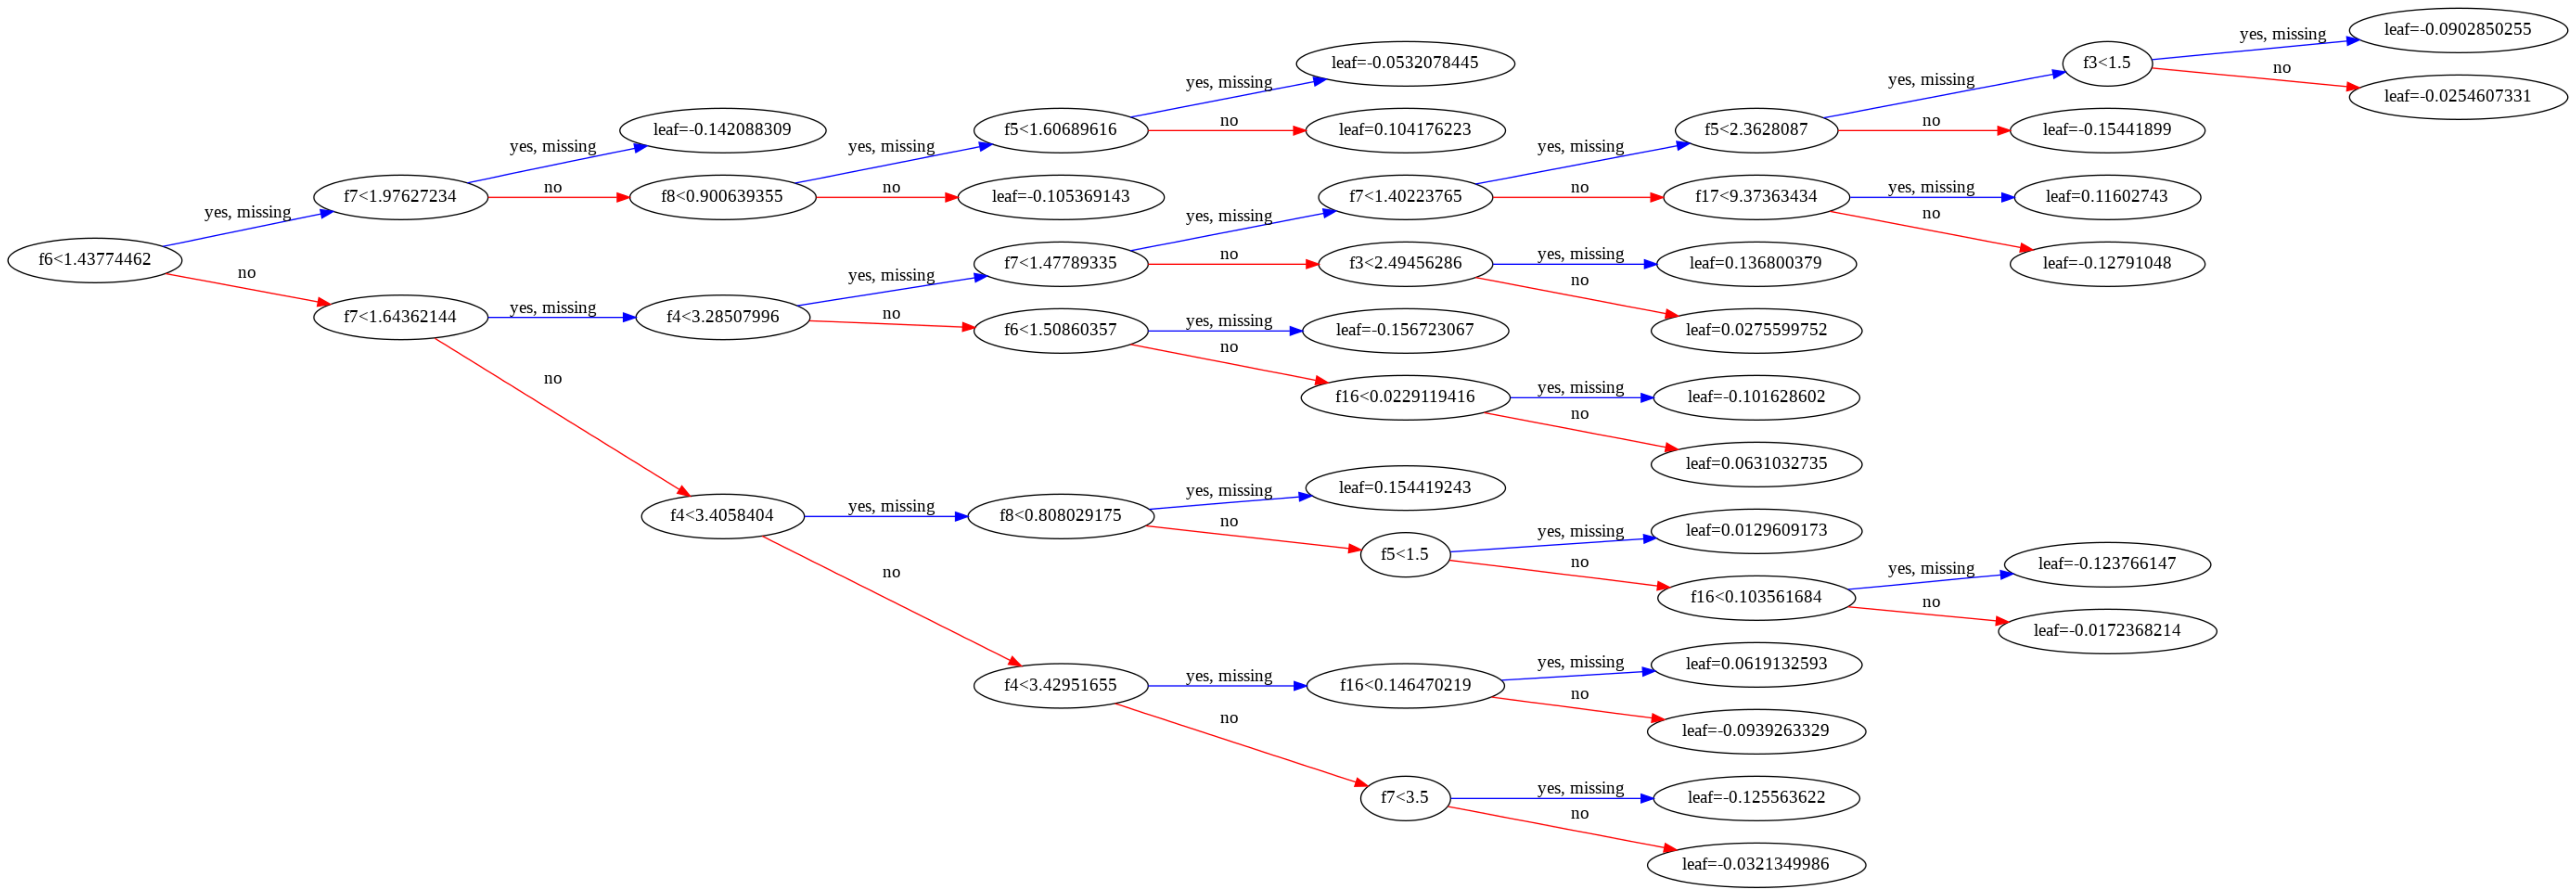

In [79]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from xgboost import plot_tree
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 100,80
best_model = gs.best_estimator_
tree_plot = plot_tree(best_model, num_trees = 2, rankdir='LR')
tree_plot

In [80]:
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
from matplotlib import pyplot
pred_auc = gs.predict_proba(X_test)
pred_auc =  pred_auc[:,1]
precision, recall, thresholds = precision_recall_curve( y_test, pred_auc)
# Find the thresholds that produces the maximum precision and recall
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
thresholds[ix]

Best Threshold=0.625576, F-Score=0.784


0.6255759

In [81]:
### Need to get the predicted probabilities
from sklearn.metrics import confusion_matrix
pred_prob =  gs.predict_proba(X_test)
prob_drop =   pd.DataFrame(pred_prob[:,1], columns = ["prob_drop"])
def if_else(row):

    if row['prob_drop'] >thresholds[ix]:

        val = 1
    
    else:

        val = 0

    return val

prob_drop = prob_drop.apply(if_else, axis=1)
prob_drop

### Get a confusion matrix and then get sensitivity by hand
con_mat = confusion_matrix(y_test, prob_drop)
#sensitivity <- TP / (TP + FN)
#specificity <- TN / (TN + FP)
con_mat
#tn, fp, fn, tp
sensitivity =  con_mat[1][1] / (con_mat[1][1] + con_mat[1][0])
specificity = con_mat[0][0] / (con_mat[0][0] + con_mat[0][1])
accuracy = (con_mat[1][1] + con_mat[0][0]) / (con_mat[1][1] + con_mat[1][0] + con_mat[0][0] + con_mat[0][1])
### 
balanced_accuracy =  (sensitivity+specificity)/2

sensitivity = pd.DataFrame(sensitivity, columns = ["sensitivity"], index = [0])
specificity = pd.DataFrame(specificity, columns = ["specificity"], index = [0])
accuracy = pd.DataFrame(accuracy, columns = ["accuracy"], index = [0 ])
balanced_accuracy = pd.DataFrame(balanced_accuracy, columns = ["balanced_accuracy"], index = [0])

frames = [sensitivity, specificity, balanced_accuracy, accuracy]
metrics_dat = pd.concat(frames, axis = 1)
metrics_dat = metrics_dat.round(2)
metrics_dat

,sensitivity,specificity,balanced_accuracy,accuracy
0,0.63,1.0,0.81,0.91


In [82]:
### Need to get the predicted probabilities
pred_prob =  gs.predict_proba(X_test)
prob_drop =   pd.DataFrame(pred_prob[:,1], columns = ["prob_drop"])
def if_else(row):

    if row['prob_drop'] > thresholds[ix]:

        val = "very high risk"

    elif row['prob_drop'] >thresholds[ix] / 2:

        val = "high risk "
    
    elif row['prob_drop'] > thresholds[ix] / 3:
        
        val = "medium risk"
    
    else:

        val = "low risk"

    return val

prob_drop['risk_level'] = prob_drop.apply(if_else, axis=1)
prob_drop['risk_level'].value_counts()
        

low risk          201
very high risk     37
medium risk        12
high risk           8
Name: risk_level, dtype: int64

Try saving the model

In [84]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
#auth.authenticate_user()
#gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

Now trying to save the model in google drive

In [86]:
import pickle
import joblib
gs_drop_9_24_20 = gs 
gs_drop_9_24_20 = 'gs_drop_9_24_20.pkl'
model_file = drive.CreateFile({'title' : 'gs_drop_9_24_20.pkl'})                     
model_file.Upload()
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1G4j1CTUR7TxRmb41g3vwK2cIIq2GGoD2', 'kind': 'drive#file', 'etag': '"MTYwMDg3NTU4ODE5NQ"', 'selfLink': 'https://www.googleapis.com/drive/v2/files/1G4j1CTUR7TxRmb41g3vwK2cIIq2GGoD2', 'webContentLink': 'https://drive.google.com/uc?id=1G4j1CTUR7TxRmb41g3vwK2cIIq2GGoD2&export=download', 'alternateLink': 'https://drive.google.com/file/d/1G4j1CTUR7TxRmb41g3vwK2cIIq2GGoD2/view?usp=drivesdk', 'embedLink': 'https://drive.google.com/file/d/1G4j1CTUR7TxRmb41g3vwK2cIIq2GGoD2/preview?usp=drivesdk', 'iconLink': 'https://drive-thirdparty.googleusercontent.com/16/type/application/octet-stream', 'title': 'gs_drop_9_23_20.pkl', 'mimeType': 'application/octet-stream', 'labels': {'starred': False, 'hidden': False, 'trashed': True, 'restricted': False, 'viewed': True}, 'copyRequiresWriterPermission': False, 'createdDate': '2020-09-23T15:39:48.195Z', 'modifiedDate': '2020-09-23T15:39:48.195Z', 'modifiedByMeDate': '2020-09-23T15:39:48.195Z', 'lastViewedByMeDate': '2020-09-23T15:44:16.3

Still working on how to get the model loaded

In [ ]:
load_model = drive.CreateFile({'id': '1G4j1CTUR7TxRmb41g3vwK2cIIq2GGoD2'})
load_model.GetContentFile('gs_drop_9_24_20.pkl')
load_model

In [87]:
# Just a few variables for testing out in streamlit
#best_model
X_train_short =  X_train[:,0:2]
X_test_short =  X_test[:,0:2]
load_model.fit(X_train_short, y_train)

AttributeError: ignored